# Régression par processus gaussiens

## Charles-Meldhine Madi Mnemoi, Lucas Terra, Marwa Tourabi et Youssef Saidi

* [Import des libraries et des données](#Import-des-libraries-et-des-données)
* [Analyse exploratoire](#Analyse-exploratoire)
* [Modélisation](#Modélisation)
  * [Analyse des premiers résultats](#Analyse-des-premiers-résultats)
  * [Tests de différentes fonctions de covariance](#Tests-de-différentes-fonctions-de-covariance)
  * [Optimisation des hyperparamètres](#Optimisation-des-hyperparamètres)
  * [Comparaison des modèles sur le jeu de test](#Comparaison-des-modèles-sur-le-jeu-de-test)
* [Interprétation des résultats](#Interprétation-des-résultats)

L'objectif de ce projet est d'effectuer une régression à l'aide d'un processus gaussien développé de zéro sur le jeu de données `age.income` (Uallah, 1985) qui regroupe des données sur le revenus de 205 Canadiens.

# Import des libraries et des données <a class="anchor" id="Import-des-libraries-et-des-données"></a>

In [26]:
import numpy as np # Manipulation de vecteurs et matrices
import pandas as pd # Manipulation de tableaux de données
import matplotlib.pyplot as plt # Graphiques (bas niveau)
import seaborn as sns # Graphiques (haut niveau)
sns.set()

from GaussianProcess import GaussianProcess
from model_selection import fix_random_seed, train_test_split
from plot import plot_train_and_val, plot_confidence_and_interval

SEED = 42
fix_random_seed(SEED)

data = pd.read_table('ageIncome.txt', sep='\t', index_col=0)

# Analyse exploratoire <a class="anchor" id="Analyse-exploratoire"></a>

In [27]:
data

,age,log.income
1,21,11.1563
2,22,12.8131
3,22,13.0960
4,22,11.6952
5,22,11.5327
...,...,...
201,63,13.9682
202,63,12.0782
203,63,14.0916
204,64,13.7102


Le dataset est composé d'une variable explicative `age` et d'une variable cible `log.income`.

Nous allons séparer le dataset en trois :
- un jeu d'entraînement pour estimer les paramètres du processus gaussien (50% des données)
- un jeu de validation pour optimiser les hyperparamètres $\theta$ et $\sigma_{noise}$ (30% des données)
- un jeu de test pour évaluer la performance du modèle (20% des données)

In [28]:
train_data, val_data = train_test_split(data, test_size=0.5, random_state=SEED)
val_data, test_data = train_test_split(val_data, test_size=0.33, random_state=SEED)

X_train = train_data.age.values.ravel()
y_train = train_data['log.income'].values.ravel()
X_val = val_data.age.values.ravel()
y_val = val_data['log.income'].values.ravel()
X_test = test_data.age.values.ravel()
y_test = test_data['log.income'].values.ravel()

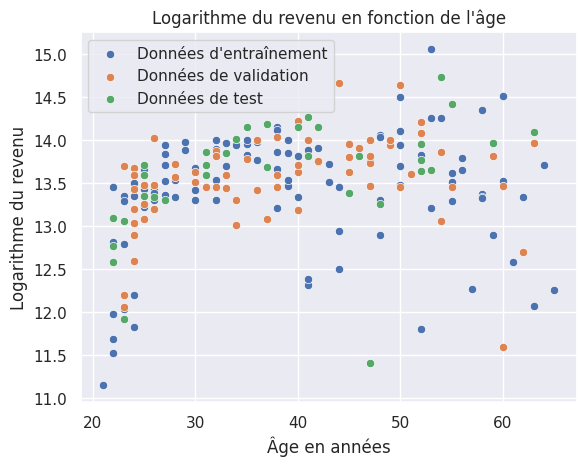

In [29]:
sns.scatterplot(data=train_data, x='age', y='log.income')
sns.scatterplot(data=val_data, x='age', y='log.income')
sns.scatterplot(data=test_data, x='age', y='log.income')

plt.title("Logarithme du revenu en fonction de l'âge")
plt.xlabel("Âge en années")
plt.ylabel("Logarithme du revenu")
plt.legend(['Données d\'entraînement', 'Données de validation', 'Données de test'])

On voit que les jeux d'entraînement, de validation et de test sont similaires, l'entraînement ne sera donc pas biaisé par la sélection des données.

# Modélisation <a class="anchor" id="Modélisation"></a>

## Premiers résultats <a class="anchor" id="Analyse-des-premiers-résultats"></a>

Il suffit d'appeler la méthode `.fit()` pour estimer les paramètres du processus gaussien sur nos données d'entraînement, puis `.predict()` pour prédire le revenu sur le jeu d'entraînement et de validation.

In [30]:
matern_gaussian_process = GaussianProcess(kernel='matern')
matern_gaussian_process.fit(X_train, y_train)

y_train_pred, _ = matern_gaussian_process.predict(X_train)
y_val_pred, _ = matern_gaussian_process.predict(X_val)

<Figure size 500x1000 with 0 Axes>

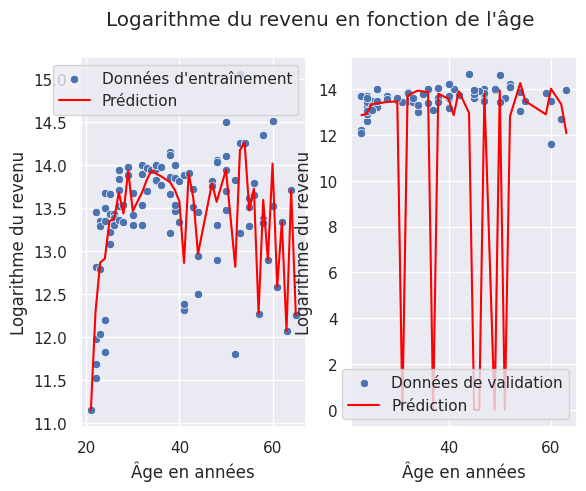

In [31]:
plot_train_and_val(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred)

On observe que le processus colle beaucoup au jeu d'entraînement mais beaucoup moins au jeu de validation. Nous sommes vraisemblement en présence d'un sur-apprentissage (ou overfitting) : le modèle n'est pas capable de généraliser sur de nouvelles données.

![overfitting](overfitting.webp)

On peut s'en assurer en comparant l'erreur quadratique moyenne (EQM) sur le jeu d'entraînement et de validation définie par : $$EQM = \frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat{y}_{i})^{2}$$ à l'aide de la méthode `.score()`.
Si l'erreur sur le jeu d'entraînement est beaucoup plus faible que celle sur le jeu de validation, alors on est en présence d'un sur-apprentissage.

In [32]:
print(f"Erreur quadratique moyenne sur les données d'entraînement: {matern_gaussian_process.score(X_train, y_train)}")
print(f"Erreur quadratique moyenne sur les données de validation: {matern_gaussian_process.score(X_val, y_val)}")

Erreur quadratique moyenne sur les données d'entraînement: 0.16581542337331287
Erreur quadratique moyenne sur les données de validation: 27.95813575770751


## Tests de différentes fonctions de covariance <a class="anchor" id="Tests-de-différentes-fonctions-de-covariance"></a>

Nous pouvons tenter d'utiliser une autre fonction de covariance pour voir si le problème vient de la fonction choisie.
Nous avons implémenté les fonctions suivantes (inspirées de l'implémentation de Scikit-learn) :
- la fonction gaussienne : $$k(x, x') = exp(-\frac{(x - x')^{2}}{2\theta^{2}})$$
- la fonction rational quadratic (RQ) : $$k(x, x') = 1 + \frac{(x - x')^{2}}{2\theta^{2}}$$

<Figure size 500x1000 with 0 Axes>

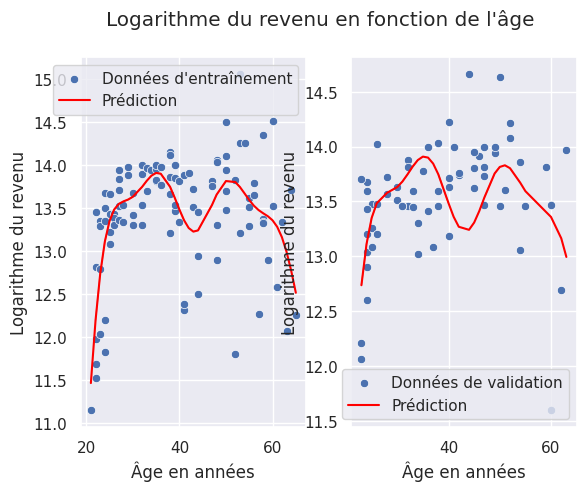

In [33]:
gaussian_kernel_gaussian_process = GaussianProcess(kernel='gaussian')
gaussian_kernel_gaussian_process.fit(X_train, y_train)

y_train_pred, _ = gaussian_kernel_gaussian_process.predict(X_train)
y_val_pred, _ = gaussian_kernel_gaussian_process.predict(X_val)

plot_train_and_val(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred)

In [34]:
print(f"Erreur quadratique moyenne sur les données d'entraînement: {gaussian_kernel_gaussian_process.score(X_train, y_train)}")
print(f"Erreur quadratique moyenne sur les données de validation: {gaussian_kernel_gaussian_process.score(X_val, y_val)}")

Erreur quadratique moyenne sur les données d'entraînement: 0.270909732671763
Erreur quadratique moyenne sur les données de validation: 0.2480254449335573


<Figure size 500x1000 with 0 Axes>

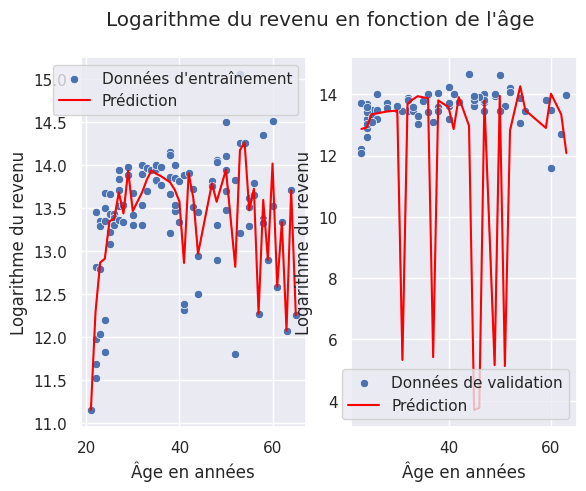

In [35]:
rq_kernel_gaussian_process = GaussianProcess(kernel='rational_quadratic')
rq_kernel_gaussian_process.fit(X_train, y_train)

y_train_pred, _ = rq_kernel_gaussian_process.predict(X_train)
y_val_pred, _ = rq_kernel_gaussian_process.predict(X_val)

plot_train_and_val(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred)

In [36]:
print(f"Erreur quadratique moyenne sur les données d'entraînement: {rq_kernel_gaussian_process.score(X_train, y_train)}")
print(f"Erreur quadratique moyenne sur les données de validation: {rq_kernel_gaussian_process.score(X_val, y_val)}")

Erreur quadratique moyenne sur les données d'entraînement: 0.1658154214895222
Erreur quadratique moyenne sur les données de validation: 12.571020054567107


On observe qu'on a à apriori un meilleur résultat avec la fonction gaussienne.

## Optimisation des hyperparamètres <a class="anchor" id="Optimisation-des-hyperparamètres"></a>

Pour améliorer le résultat, on peut procéder à l'optimisation des hyperparamètres $\theta$ et $\sigma_{noise}$ à l'aide de la méthode `.optimize()`.

Cette méthode utilise la méthode de Newton-Raphson pour trouver les $\theta$ et $\sigma_{noise}$ qui maximisent la log-vraisemblance du processus gaussien définie par :

$$\log p(y|\theta, \sigma_{noise}) = \frac{1}{2}y^{T}K_y^{-1}y - \frac{1}{2}\log |K_y| - \frac{n}{2}\log(2\pi)$$ 

où $K_y$ est la matrice de covariance bruitée par $\sigma_{noise}$ des données de validation (C. E. Rasmussen et C. K.I. Williams, 2005).

In [37]:
print("Avant optimisation, les hyperparamètres sont:")
print("theta =", matern_gaussian_process.theta)
print("sigma_noise =", matern_gaussian_process.noise)

Avant optimisation, les hyperparamètres sont:
theta = 0.1
sigma_noise = 1e-05


<Figure size 500x1000 with 0 Axes>

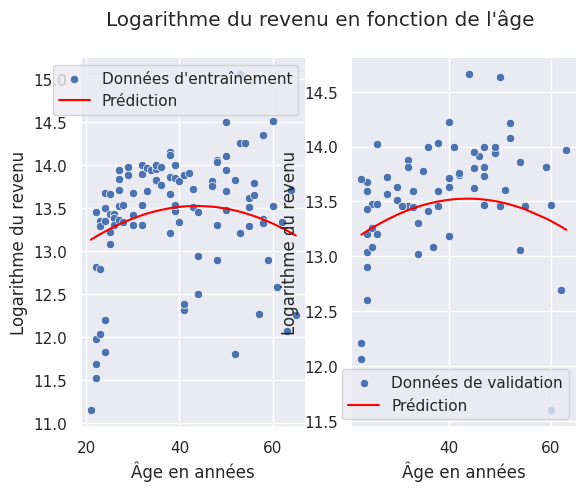

In [38]:
matern_gaussian_process.optimize(X_val, y_val)

y_train_pred, _ = matern_gaussian_process.predict(X_train)
y_val_pred, _ = matern_gaussian_process.predict(X_val)

plot_train_and_val(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred)

In [39]:
print(f"Erreur quadratique moyenne sur les données d'entraînement: {matern_gaussian_process.score(X_train, y_train)}")
print(f"Erreur quadratique moyenne sur les données de validation: {matern_gaussian_process.score(X_val, y_val)}")

Erreur quadratique moyenne sur les données d'entraînement: 0.41000308661584495
Erreur quadratique moyenne sur les données de validation: 0.23559557841002932


<Figure size 500x1000 with 0 Axes>

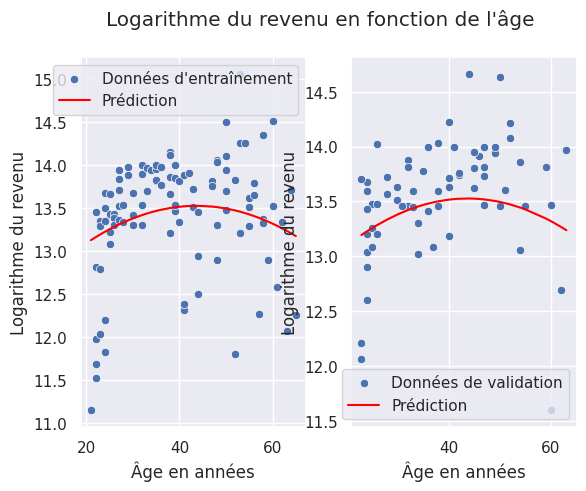

In [40]:
gaussian_kernel_gaussian_process.optimize(X_val, y_val)

y_train_pred, _ = gaussian_kernel_gaussian_process.predict(X_train)
y_val_pred, _ = gaussian_kernel_gaussian_process.predict(X_val)

plot_train_and_val(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred)

In [41]:
print(f"Erreur quadratique moyenne sur les données d'entraînement: {gaussian_kernel_gaussian_process.score(X_train, y_train)}")
print(f"Erreur quadratique moyenne sur les données de validation: {gaussian_kernel_gaussian_process.score(X_val, y_val)}")

Erreur quadratique moyenne sur les données d'entraînement: 0.40897734173651173
Erreur quadratique moyenne sur les données de validation: 0.2351065380607953


<Figure size 500x1000 with 0 Axes>

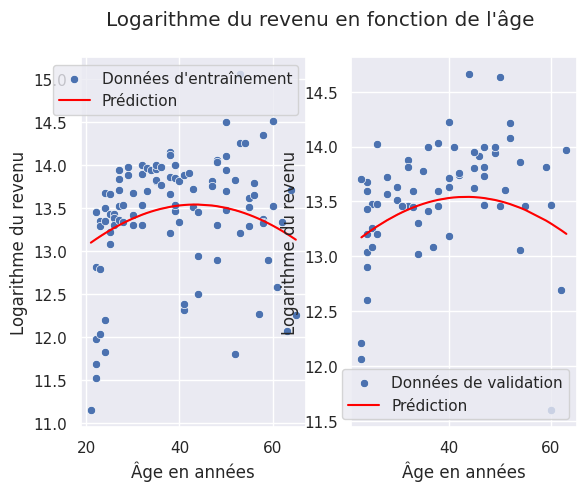

In [42]:
rq_kernel_gaussian_process.optimize(X_val, y_val)

y_train_pred, _ = rq_kernel_gaussian_process.predict(X_train)
y_val_pred, _ = rq_kernel_gaussian_process.predict(X_val)

plot_train_and_val(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred)

In [43]:
print(f"Erreur quadratique moyenne sur les données d'entraînement: {rq_kernel_gaussian_process.score(X_train, y_train)}")
print(f"Erreur quadratique moyenne sur les données de validation: {rq_kernel_gaussian_process.score(X_val, y_val)}")

Erreur quadratique moyenne sur les données d'entraînement: 0.4037557801202349
Erreur quadratique moyenne sur les données de validation: 0.23101355882414254


On voit qu'après optimisation des hyperparamètres, on obtient un meilleur résultat sur le jeu de validation et que l'erreur reste très faible sur le jeu d'entraînement.

In [44]:
print("Après optimisation, les hyperparamètres sont:")
print("theta:", matern_gaussian_process.theta)
print("sigma_noise:", matern_gaussian_process.noise)

Après optimisation, les hyperparamètres sont:
theta: 119.76938056403648
sigma_noise: 0.6972697420103731


## Comparaison des modèles sur le jeu de test <a class="anchor" id="Comparaison-des-modèles-sur-le-jeu-de-test"></a>

On peut maintenant comparer les modèles sur le jeu de test pour voir lequel est le plus performant.

Text(0, 0.5, 'Logarithme du revenu')

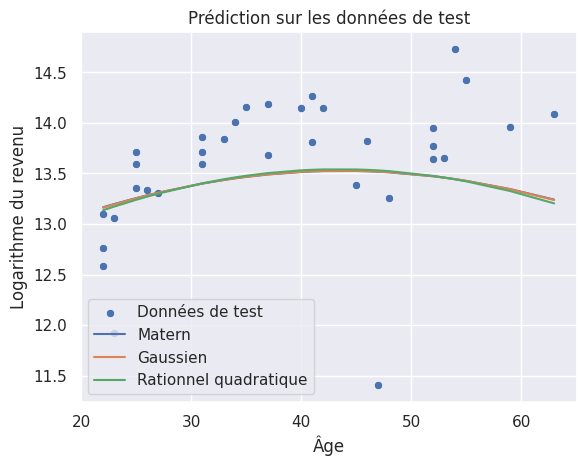

In [45]:
y1_test_pred, _ = matern_gaussian_process.predict(X_test)
y2_test_pred, _ = gaussian_kernel_gaussian_process.predict(X_test)
y3_test_pred, _ = rq_kernel_gaussian_process.predict(X_test)

sns.scatterplot(x=X_test, y=y_test, label='Données de test')
sns.lineplot(x=X_test, y=y1_test_pred, label='Matern')
sns.lineplot(x=X_test, y=y2_test_pred, label='Gaussien')
sns.lineplot(x=X_test, y=y3_test_pred, label='Rationnel quadratique')
plt.title('Prédiction sur les données de test')
plt.xlabel("Âge")
plt.ylabel("Logarithme du revenu")

In [46]:
print(f"Erreur quadratique moyenne sur les données de test avec le noyau de Matern: {matern_gaussian_process.score(X_test, y_test)}")
print(f"Erreur quadratique moyenne sur les données de test avec le noyau gaussien: {gaussian_kernel_gaussian_process.score(X_test, y_test)}")
print(f"Erreur quadratique moyenne sur les données de test avec le noyau rationnel quadratique: {rq_kernel_gaussian_process.score(X_test, y_test)}")

Erreur quadratique moyenne sur les données de test avec le noyau de Matern: 0.42675736250644736
Erreur quadratique moyenne sur les données de test avec le noyau gaussien: 0.42613618954456434
Erreur quadratique moyenne sur les données de test avec le noyau rationnel quadratique: 0.4244072444820659


On peut voir que c'est la fonction RQ qui est la plus performante, bien que la différence soit minime.

# Interprétation des résultats <a class="anchor" id="Interprétation-des-résultats"></a>

Une interprétation de l'erreur quadratique moyenne peut être effectuée à l'aide de sa racine carrée (RMSE) qui est de la même unité que la variable cible.

In [47]:
print(f"RMSE sur les données de test avec le noyau rationnel quadratique: {np.sqrt(rq_kernel_gaussian_process.score(y_test, y3_test_pred))}")

RMSE sur les données de test avec le noyau rationnel quadratique: 0.6236173068914604


La RMSE est d'environ 0.62. Cela signifie que notre modèle prédit en moyenne le logarithme du revenu à 0.62 près.

On peut tracer l'intervalle de confiance à 95% de notre modèle :

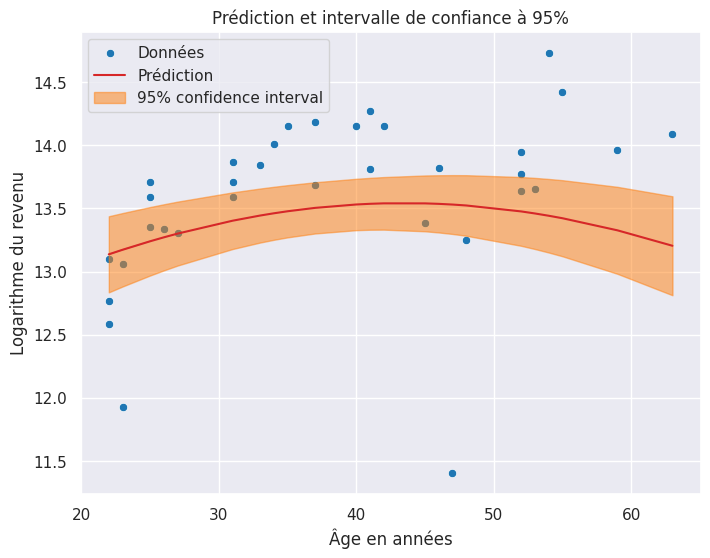

In [48]:
l, u = plot_confidence_and_interval(rq_kernel_gaussian_process, X_test, y_test)